# Introduction

In the following script, I show how to use monthly dummy variables and linear regression to capture monthly seasonality. This approach is specially
useful when trying to establish the relationship and effect of each month on sales.

How does this approach work:

1. Choose one month as a “baseline” (often January) and omit it from your regression to avoid perfect multicollinearity.

2. Create 11 dummy variables—one for each of the remaining months—where each dummy variable is 1 if an observation belongs to that month and 0 otherwise.

3. Include these dummy variables as predictors in your regression, along with any trend or other explanatory variables.

## Step 1: creating dataset

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


np.random.seed(42)  # For reproducibility

n = 24  # 24 months (2 years)

dates = pd.date_range(start="2023-01-01", periods=n, freq="M")

df = pd.DataFrame({'date': dates})
df['month'] = df['date'].dt.month
df['time'] = np.arange(n)  # A simple time index to represent trend

monthly_effects = {
    1: 0, 2: 2, 3: -1, 4: 3, 5: 0,
    6: -2, 7: 4, 8: -1, 9: 1, 10: 0, 11: 2, 12: -3
}

df['month_effect'] = df['month'].map(monthly_effects) # effect of each month on sales 

df['trend'] = 0.5 * df['time'] 

noise = np.random.normal(scale=1, size=n)

df['sales'] = 10 + df['trend'] + df['month_effect'] + noise


df


C:\Users\Ahmed Ahmed\AppData\Local\Temp\ipykernel_8060\778431121.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2023-01-01", periods=n, freq="M")


,date,month,time,month_effect,trend,sales
0,2023-01-31,1,0,0,0.0,10.496714
1,2023-02-28,2,1,2,0.5,12.361736
2,2023-03-31,3,2,-1,1.0,10.647689
3,2023-04-30,4,3,3,1.5,16.023030
4,2023-05-31,5,4,0,2.0,11.765847
5,2023-06-30,6,5,-2,2.5,10.265863
6,2023-07-31,7,6,4,3.0,18.579213
7,2023-08-31,8,7,-1,3.5,13.267435
8,2023-09-30,9,8,1,4.0,14.530526
9,2023-10-31,10,9,0,4.5,15.042560


Components of sales:

- 10: A base level of sales. This means that, regardless of trend or seasonality, the starting sales value is 10 units.

- df['trend']: The linear trend component that increases by 0.5 each month, simulating gradual growth in sales.

- df['month_effect']: The seasonal effect for each month, as defined in the monthly_effects dictionary. This adds or subtracts a specific value depending on the month.

- noise: The random error component generated from a normal distribution to mimic real-world variability.

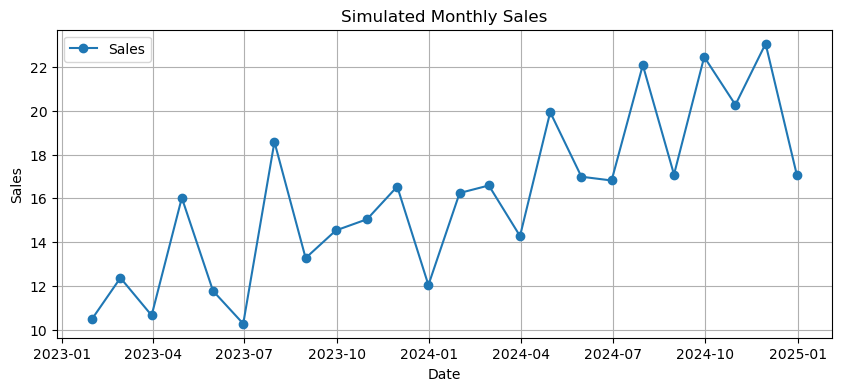

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['sales'], marker='o', label='Sales')
plt.title("Simulated Monthly Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()


## Fitting a model

In [26]:
# Using pandas get_dummies; drop_first=True drops January (month=1) as baseline.


dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
X = pd.concat([df[['trend']], dummies], axis=1)
X = X.astype(float)

y = df['sales']
X = sm.add_constant(X)


In [27]:
# -------------------------------
# 3. Fit the regression model
# -------------------------------

model = sm.OLS(y, X).fit()


In [28]:
print(X.dtypes)
print(y.dtype)


const       float64
trend       float64
month_2     float64
month_3     float64
month_4     float64
month_5     float64
month_6     float64
month_7     float64
month_8     float64
month_9     float64
month_10    float64
month_11    float64
month_12    float64
dtype: object
float64


In [29]:
print("\nRegression Model Summary:")
print(model.summary())


Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     27.38
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           1.92e-06
Time:                        11:14:02   Log-Likelihood:                -24.208
No. Observations:                  24   AIC:                             74.42
Df Residuals:                      11   BIC:                             89.73
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8129    

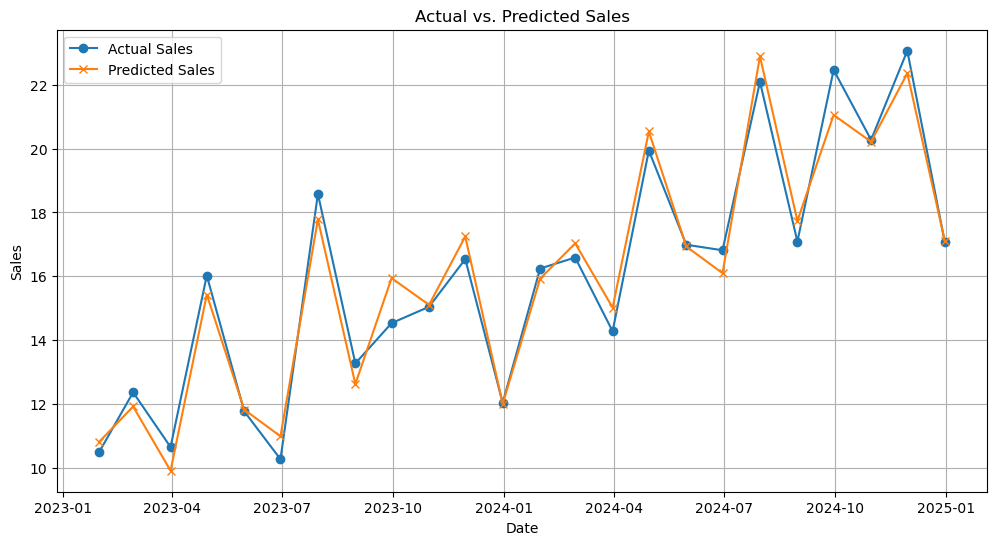

In [30]:
# Create predicted sales using the fitted model
df['predicted_sales'] = model.predict(X)

# Plot actual sales vs. predicted sales over time
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['sales'], marker='o', label='Actual Sales')
plt.plot(df['date'], df['predicted_sales'], marker='x', label='Predicted Sales')
plt.title("Actual vs. Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()


## Sales forcasting

In [51]:
# Define how many months ahead you want to forecast.
n_future = 12  # for example, forecast for the next 12 months

last_date = df['date'].iloc[-1]

future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_future, freq='M')


future_df = pd.DataFrame({'date': future_dates})

future_df['month'] = future_df['date'].dt.month

future_df['time'] = np.arange(len(df), len(df) + n_future)

future_df['trend'] = 0.5 * future_df['time']

future_dummies = pd.get_dummies(future_df['month'], prefix='month', drop_first=True)

for col in dummies.columns:
    if col not in future_dummies:
        future_dummies[col] = 0


future_dummies = future_dummies[dummies.columns]

X_future = pd.concat([future_df[['trend']], future_dummies], axis=1)
X_future = sm.add_constant(X_future)
future_df['predicted_sales'] = model.predict(X_future)


C:\Users\Ahmed Ahmed\AppData\Local\Temp\ipykernel_8060\1573721072.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_future, freq='M')


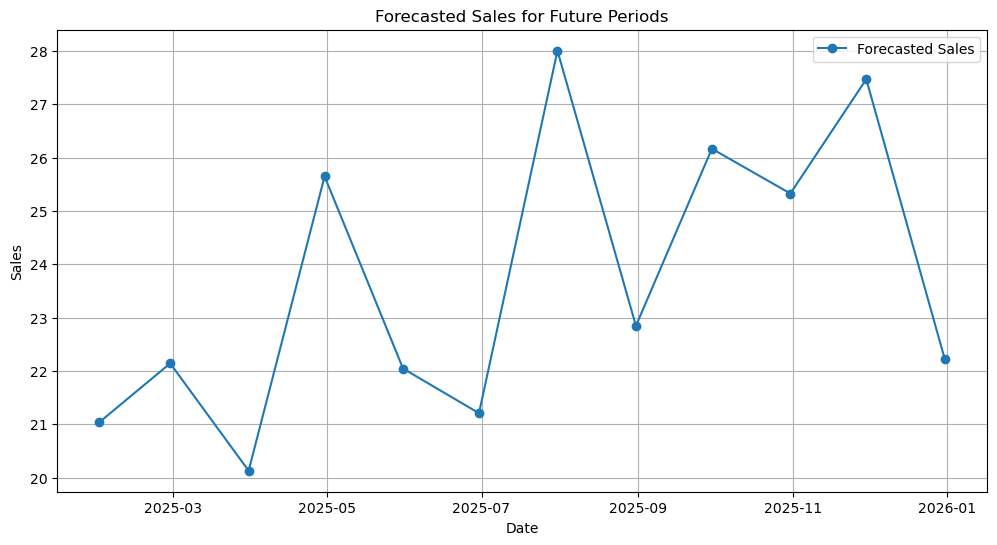

In [53]:
plt.figure(figsize=(12,6))
plt.plot(future_df['date'], future_df['predicted_sales'], marker='o', linestyle='-', label='Forecasted Sales')
plt.title('Forecasted Sales for Future Periods')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.show()
